# MLM Phase


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import warnings
import re

from transformers import CamembertTokenizer, CamembertForSequenceClassification
from transformers import Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
import pandas as pd

#!pip install datasets
!pip install wandb
!pip install Trainer
!pip install accelerate -U
!pip install transformers[torch]

warnings.filterwarnings('ignore')

# PyTorch
import torch
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler, Dataset, Subset

# Hugging Face Transformers
from transformers import CamembertTokenizer, CamembertTokenizerFast, CamembertForMaskedLM, CamembertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from transformers import TrainerCallback
from transformers import Trainer
from transformers import TrainingArguments


# Scikit-learn packages for modeling and evaluation
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split



In [ ]:
labeled_df = pd.read_csv( "labeled_df.csv")
labeled_df = labeled_df[['label', 'id', 'text']]
labeled_df.head()

,label,id,text
0,0,02XWR02BCE,"Crise sanitaire, recrutements, succession… Les..."
1,0,03URLSTT7L,Transfert de l’énergie solaire depuis l’espace...
2,1,08XCWWYT57,Des céréales ukrainiennes vers l’Afrique : le ...
3,1,09746LR4F6,Les députés en séance plénière pour l'examen d...
4,1,09QJEPKIPQ,"L’ANSD relève une progression de 0, 8 % de l’i..."


In [ ]:
def clean_text(text):
    """
    Remove URLs and other unwanted patterns from the text.
    """
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # Remove lines with dashes or similar patterns
    text = re.sub(r'-{2,}', '', text)

    # Remove emails or specific patterns (example)
    text = re.sub(r'\S*@\S*\s?', '', text)

    # Any additional cleaning steps can be added here

    return text

# Apply the cleaning function to your DataFrame directly on the text column
labeled_df['text'] = labeled_df['text'].apply(clean_text)  # Repla
labeled_df.head()

,label,id,text
0,0,02XWR02BCE,"Crise sanitaire, recrutements, succession… Les..."
1,0,03URLSTT7L,Transfert de l’énergie solaire depuis l’espace...
2,1,08XCWWYT57,Des céréales ukrainiennes vers l’Afrique : le ...
3,1,09746LR4F6,Les députés en séance plénière pour l'examen d...
4,1,09QJEPKIPQ,"L’ANSD relève une progression de 0, 8 % de l’i..."


In [ ]:
exclusion_list = [
    '.',',',':','"','?','!','%','(',')'
    # Definite articles
    'le', 'la', 'les', 'l\'',
    # Indefinite articles
    'un', 'une', 'des',
    # Partitive articles
    'du', 'de', "d", 'des', "'",
    # Prepositions
    'à', 'au', 'aux', 'avec', 'chez', 'contre', 'dans', 'de', 'depuis', 'derrière',
    'devant', 'durant', 'en', 'entre', 'envers', 'hors', 'jusque', 'malgré',
    'par', 'parmi', 'pendant', 'pour', 'près', 'sans', 'selon', 'sous', 'sur',
    'vers', 'via', 'voilà',
    # Conjunctions
    'et', 'ou', 'mais', 'donc', 'or', 'ni', 'car', 'que',
    # Pronouns
    'je', 'tu', 'il', 'elle', 'nous', 'vous', 'ils', 'elles', 'on',
    'me', 'te', 'se', 'le', 'la', 'les', 'lui', 'leur', 'eux', 'elles',
    'ce', 'cela', 'ça', 'celui', 'celle', 'ceux', 'celles',
    'qui', 'que', 'quoi', 'dont', 'où',
    # Possessive adjectives
    'mon', 'ton', 'son', 'notre', 'votre', 'leur', 'ma', 'ta', 'sa', 'mes', 'tes', 'ses', 'nos', 'vos', 'leurs',
    # Demonstrative adjectives
    'ce', 'cet', 'cette', 'ces',
    # Negations
    'ne', 'pas', 'jamais', 'rien',
    # Adverbs
    'ici', 'là', 'où', 'quand', 'comment', 'pourquoi', 'combien',
    # Miscellaneous
    'est', 'sont', 'était', 'étaient', 'sera', 'seront', 'a', 'ont', 'avait', 'avaient', 'aura', 'auront','c’'
]

priority_vocab = ['plantation', 'élevage', 'céréale', 'légumineux', 'fruit', 'légume', 'riz', 'blé', 'maïs', 'mil', 'sorgo',
            'viande', 'sécheresse', 'pluie', 'érosion', 'désertification', 'déforestation', 'cultivée',
            'rendement', 'parasitaire', 'd\'eau', 'manque', 'niveau',
            'fourragère', 'céréalière', 'semis', 'déforestation',
            'criquet', 'agricole', 'engrai', 'bouture', 'semence',
             'pesticide', 'intrant', 'agriculture', 'rente', 'épizootie',
            'pmarché', 'prix', 'nourriture', 'soudure', 'actif',
             'misère', 'd\'achat', 'foncier',
            'source', 'faim', 'nutrition', 'calorique', 'pain', 'anémie', 'alimentaire', 'insécurité ', 'humanitaire', 'famine', 'pauvreté', 'vulnérabilité', 'crise', 'flambée', 'pèlerin',
            'insuffisante','inondation','aliment']

In [ ]:
from torch.utils.data import Dataset, DataLoader
from transformers import CamembertTokenizer
import torch
import numpy as np
import pandas as pd

class CamemBERTDataset(Dataset):
    def __init__(self, dataframe, tokenizer: CamembertTokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.dataframe = dataframe
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.dataframe.iloc[idx]['text']
        inputs = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, truncation=True, padding='max_length', return_offsets_mapping=True)
        offset_mapping = inputs.pop('offset_mapping').squeeze()  # Offset mapping is not needed for training

        masked_input_ids, labels = self.apply_masking_logic(inputs['input_ids'].squeeze(), inputs['attention_mask'].squeeze())

        return {'input_ids': masked_input_ids, 'attention_mask': inputs['attention_mask'].squeeze(), 'labels': labels}

    def apply_masking_logic(self, input_ids, attention_mask):
        return adapted_mask_random_tokens(input_ids, attention_mask, self.tokenizer)

def adapted_mask_random_tokens(input_ids, attention_mask, tokenizer, masking_ratio=0.15, priority_ratio=0.3):
    seq_length = attention_mask.sum().item()
    special_tokens_mask = tokenizer.get_special_tokens_mask(input_ids.tolist(), already_has_special_tokens=True)

    # Identify tokens for priority and exclusion based on global priority_vocab and exclusion_list
    priority_indices = [i for i, token in enumerate(input_ids[:seq_length]) if tokenizer.decode([token], skip_special_tokens=True).strip() in priority_vocab]
    eligible_tokens = [i for i, token in enumerate(input_ids[:seq_length]) if i not in priority_indices and special_tokens_mask[i] == 0 and tokenizer.decode([token], skip_special_tokens=True).strip() not in exclusion_list]

    # Calculate number of tokens to mask
    total_tokens_to_mask = int(seq_length * masking_ratio)
    max_priority_tokens = int(total_tokens_to_mask * priority_ratio)
    num_priority_to_mask = min(len(priority_indices), max_priority_tokens)
    num_regular_to_mask = total_tokens_to_mask - num_priority_to_mask

    # Select indices for masking
    priority_masked_indices = np.random.choice(priority_indices, num_priority_to_mask, replace=False) if priority_indices else []
    regular_masked_indices = np.random.choice(eligible_tokens, num_regular_to_mask, replace=False) if eligible_tokens else []
    indices_to_mask = np.concatenate((priority_masked_indices, regular_masked_indices)).astype(int).tolist()

    labels = -100 * torch.ones_like(input_ids)  # Initialize labels with -100 for ignored tokens
    for idx in indices_to_mask:
        labels[idx] = input_ids[idx]  # Set the label for masked tokens
        input_ids[idx] = tokenizer.mask_token_id  # Apply mask

    return input_ids, labels

# Initialize the tokenizer
#tokenizer = CamembertTokenizer.from_pretrained('camembert-base')



In [ ]:
# Initialize the fast tokenizer
tokenizer = CamembertTokenizerFast.from_pretrained('camembert-base')

# Create your dataset with the test text
test_text = "C’est tout une bonne nouvelle pour un pays où le prix du pain a déjà été multiplié par dix ces derniers mois."
test_df = pd.DataFrame({'text': [test_text]})
dataset = CamemBERTDataset(test_df, tokenizer)

# Get the first item from the dataset
item = dataset[0]

# Decode the masked input_ids to visualize the text with masks
masked_text_decoded = tokenizer.decode(item['input_ids'])

print("Original text:", test_text)
print("Masked text:", masked_text_decoded)

Original text: C’est tout une bonne nouvelle pour un pays où le prix du pain a déjà été multiplié par dix ces derniers mois.
Masked text: <s><mask>’est tout une bonne<mask> pour un pays où le prix du<mask> a<mask> été multiplié par dix ces derniers mois.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the data into training and temporary data (50%:50%)
train_df, temp_df = train_test_split(labeled_df, test_size=0.5, random_state=42)

# Splitting the temporary data into validation and test data (50%:50% of temp_df, effectively 25%:25% of original)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)



In [ ]:
train_dataset = CamemBERTDataset(train_df['text'], tokenizer)
val_dataset = CamemBERTDataset(val_df['text'], tokenizer)
test_dataset = CamemBERTDataset(test_df['text'], tokenizer)

In [ ]:
#!pip install accelerate
import accelerate
print(accelerate.__version__)

0.28.0


In [ ]:
from transformers import EvalPrediction

model = CamembertForMaskedLM.from_pretrained('camembert-base')

def compute_metrics(p: EvalPrediction):
    # Assuming p.predictions is directly the logits numpy array
    predictions = p.predictions
    labels = p.label_ids

    # Adjust logic as necessary based on your actual model's output and metric calculation needs
    pred_flat = np.argmax(predictions, axis=2).flatten()
    labels_flat = labels.flatten()

    # Mask to filter out '-100' used for non-masked tokens
    mask = labels_flat != -100
    correct = (pred_flat[mask] == labels_flat[mask]).sum()
    total = mask.sum()

    return {"accuracy": correct / total if total > 0 else 0}

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    logging_dir='./logs',
    evaluation_strategy="epoch",  # or use steps to evaluate more frequently
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=CamemBERTDataset(train_df, tokenizer),
    eval_dataset=CamemBERTDataset(val_df, tokenizer),
    compute_metrics=compute_metrics,
)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing CamembertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.922207,0.603777
2,No log,1.834913,0.617108
3,No log,1.751682,0.633957


TrainOutput(global_step=129, training_loss=1.9714350737342539, metrics={'train_runtime': 536.323, 'train_samples_per_second': 0.945, 'train_steps_per_second': 0.241, 'total_flos': 133447149868032.0, 'train_loss': 1.9714350737342539, 'epoch': 3.0})

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
save_directory = "/content/drive/My Drive/MyModel"
#trainer.save_model(save_directory)
#tokenizer.save_pretrained(save_directory)

In [ ]:
from transformers import CamembertForMaskedLM, CamembertTokenizer

# Load the model and tokenizer from the save directory

model = CamembertForMaskedLM.from_pretrained(save_directory)
tokenizer = CamembertTokenizer.from_pretrained(save_directory)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
model2 = CamembertForMaskedLM.from_pretrained('camembert-base')
tokenizer2 = CamembertTokenizerFast.from_pretrained('camembert-base')

def predict_masked_text(text):
    input_ids = tokenizer2.encode(text, return_tensors="pt")
    with torch.no_grad():
        outputs = model(input_ids)
        predictions = outputs.logits

    masked_indices = torch.where(input_ids == tokenizer.mask_token_id)[1].tolist()
    result = []

    for i, masked_index in enumerate(masked_indices, start=1):
        k = 5
        topk = torch.topk(predictions[0, masked_index], k)
        topk_tokens = [tokenizer.decode([idx]).strip() for idx in topk.indices.tolist()]
        topk_probabilities = torch.softmax(topk.values, dim=0).tolist()  # Convert logits to probabilities

        prediction_strings = [f"{token}: {prob:.2%}" for token, prob in zip(topk_tokens, topk_probabilities)]
        result.append(f"Predicted word {i}. Top {k}:\n" + "\n".join(prediction_strings))

    return "\n\n".join(result)

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing CamembertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

In [ ]:
# Create Gradio interface
!pip install gradio
import gradio as gr

iface = gr.Interface(
    fn=predict_masked_text,
    inputs="text",
    outputs="text",
    examples=[
        ["En Afrique, la <mask> <mask> reste un défi persistant, marqué par des <mask> considérables. Malgré quelques progrès, de nombreuses communautés continuent de <mask> pour accéder à une alimentation adéquate et nutritive. Les infrastructures agricoles sont souvent insuffisantes, entraînant des pertes alimentaires importantes. De plus, les politiques et les investissements sont parfois inéquitables, laissant de côté les populations les plus marginalisées. Face à ces obstacles, il est crucial de redoubler d'efforts pour garantir un avenir où chaque individu en Afrique puisse vivre sans craindre la <mask> ni la <mask>."]
    ],
    title="MLM Predictions for Masked Text",
    description="This model predicts the top replacements for masked words in a sentence. Enter a sentence with <mask> tokens to see predictions."
)

iface.launch()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.7/310.7 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 92.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 10.7 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.2-py3-none-any.whl si

# Binary classification phase

In [3]:
from transformers import CamembertTokenizer, CamembertForSequenceClassification
from transformers import Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
import pandas as pd

from sklearn.model_selection import train_test_split
from transformers import CamembertTokenizer, CamembertForSequenceClassification
from transformers import Trainer, TrainingArguments
from torch.utils.data import Dataset
import pandas as pd
import torch
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import numpy as np
import re
from google.colab import drive
drive.mount('/content/drive')

!pip install Trainer
!pip install accelerate -U
!pip install transformers[torch]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
labeled_df = pd.read_csv("labeled_df.csv")
labeled_df = labeled_df[['label', 'id', 'text']]
special_case = labeled_df[(labeled_df['id'] == 'NDBP5YOL02') & (labeled_df['label'] == 1)]
if not special_case.empty:
    # If the special case exists, remove all other 'NDBP5YOL02' entries
    labeled_df = labeled_df.drop(labeled_df[(labeled_df['id'] == 'NDBP5YOL02')].index)
    # Append the special case back to the dataframe
    labeled_df = pd.concat([labeled_df, special_case], ignore_index=True)

# Step 2: Remove all other duplicates, keeping the first occurrence
labeled_df = labeled_df.drop_duplicates(subset=['id'], keep='first')
print(labeled_df[(labeled_df['id'] == 'NDBP5YOL02') ])


     label          id                                               text
337      1  NDBP5YOL02  Gestion des cantines scolaires au Bénin : Une ...


In [5]:
df = pd.read_csv("merged_predictions_with_relevance.csv")

num_rows = len(df)
print(f"Number of rows: {num_rows}")

# Display the modified DataFrame to verify
df.head()

Number of rows: 9436


,label,id,text,predicted_label,confidence,CLS_Relevance Yes/No
0,NaN,DMAMGYZL53,La proposition du PRD sur la règle de 10%\n\nL...,0,0.857464,No (m)
1,NaN,TTRAZK9XGJ,[ VIDEO ] ------------- (ex-Destiny’s Child) m...,0,0.849603,No (m)
2,NaN,T2YIHR1I2U,"Égypte : La FSBB exprime sa "" préoccupation "" ...",0,0.853480,No (m)
3,NaN,7JS87XQ62T,"(Dossier) Cherté du supercarburant, hausse des...",1,0.705428,Yes (m)
4,NaN,A6CVE0463M,Laser du lundi : Quand ---------- se meut entr...,0,0.855187,Yes (m)


In [6]:
# Get a list of unique IDs from the modified labeled_df
unique_ids_in_labeled_df = labeled_df['id'].unique()

# Remove rows from df that have IDs matching those in labeled_df
df = df[~df['id'].isin(unique_ids_in_labeled_df)]

In [7]:
def clean_text(text):
    """
    Remove URLs and other unwanted patterns from the text.
    """
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # Remove lines with dashes or similar patterns
    text = re.sub(r'-{2,}', '', text)

    # Remove emails or specific patterns (example)
    text = re.sub(r'\S*@\S*\s?', '', text)

    # Any additional cleaning steps can be added here

    return text

In [8]:
df['text'] = df['text'].apply(clean_text)
labeled_df['text'] = labeled_df['text'].apply(clean_text)

display(labeled_df.head())
display(df.head())

label_counts = labeled_df['label'].value_counts()
print("Counts of each label:")
print(label_counts)

,label,id,text
0,0,02XWR02BCE,"Crise sanitaire, recrutements, succession… Les..."
1,0,03URLSTT7L,Transfert de l’énergie solaire depuis l’espace...
2,1,08XCWWYT57,Des céréales ukrainiennes vers l’Afrique : le ...
3,1,09746LR4F6,Les députés en séance plénière pour l'examen d...
4,1,09QJEPKIPQ,"L’ANSD relève une progression de 0, 8 % de l’i..."


,label,id,text,predicted_label,confidence,CLS_Relevance Yes/No
0,NaN,DMAMGYZL53,La proposition du PRD sur la règle de 10%\n\nL...,0,0.857464,No (m)
1,NaN,TTRAZK9XGJ,[ VIDEO ] (ex-Destiny’s Child) montre ses sei...,0,0.849603,No (m)
2,NaN,T2YIHR1I2U,"Égypte : La FSBB exprime sa "" préoccupation "" ...",0,0.853480,No (m)
4,NaN,A6CVE0463M,Laser du lundi : Quand se meut entre étau et ...,0,0.855187,Yes (m)
5,NaN,198HBJZBRZ,Covid en Chine : le bilan s'alourdit à Shangha...,0,0.867945,No (m)


Counts of each label:
1    170
0    164
Name: label, dtype: int64


In [13]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.texts = texts
        self.labels = labels
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(labels, dtype=torch.long)
        }

In [9]:
# Splitting the DataFrame into training and testing sets with stratification
from sklearn.utils import shuffle
labeled_df = shuffle(labeled_df, random_state=1)
train_df, test_df = train_test_split(labeled_df, test_size=0.2, stratify=labeled_df['label'])
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [14]:
# Load the tokenizer
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")

# Prepare the training and testing datasets
train_dataset = CustomDataset(train_df['text'], train_df['label'], tokenizer)
test_dataset = CustomDataset(test_df['text'], test_df['label'], tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:


model = CamembertForSequenceClassification.from_pretrained("/content/drive/My Drive/MyModel", num_labels=2)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=3e-5, # Where to store the fine-tuned model
    num_train_epochs=4, # Number of training epochs
    per_device_train_batch_size=6, # Batch size
    warmup_steps=50, # Number of warmup steps for learning rate scheduler
    weight_decay=0.02, # Strength of weight decay
    logging_dir='./logs', # Directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Fine-tune the model
# Fine-tune the model
trainer.train()

# Predict on the test set
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)

# Generate a confusion matrix

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at /content/drive/My Drive/MyModel and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.671900,0.653878,0.522388,0.680000,0.515152,1.000000
2,0.456800,0.462174,0.791045,0.825000,0.717391,0.970588
3,0.375400,0.311801,0.865672,0.869565,0.857143,0.882353
4,0.257600,0.319790,0.895522,0.901408,0.864865,0.941176


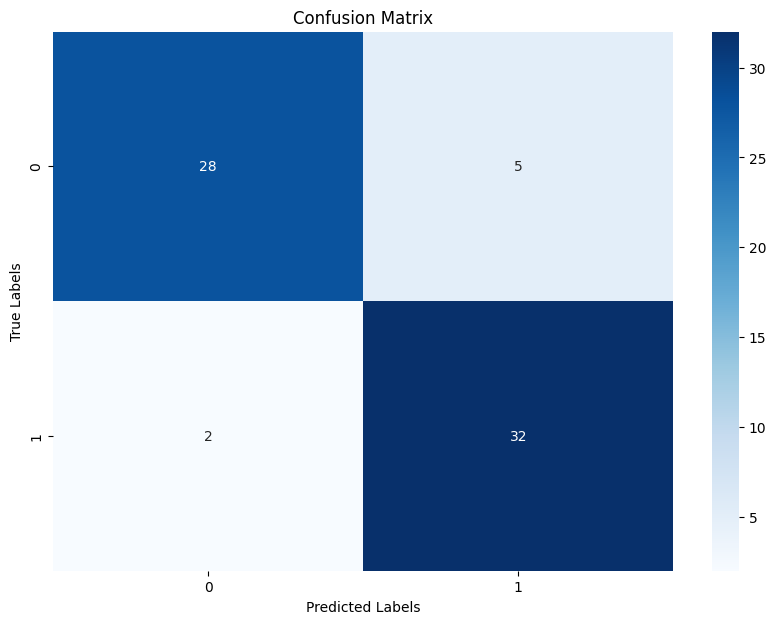

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have pred_labels and test_dataset.labels from the previous step
conf_matrix = confusion_matrix(test_dataset.labels, pred_labels)

# Visualizing the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
# Extract the actual labels from the test_dataset
actual_labels = test_dataset.labels

# Find indices of wrongly classified articles
wrong_indices = [i for i, (pred, actual) in enumerate(zip(pred_labels, actual_labels)) if pred != actual]

# Assuming your dataset has a 'text' field, extract wrongly classified texts and their predicted & actual labels
wrongly_classified_texts = [test_dataset.texts[i] for i in wrong_indices]
wrong_predictions = pred_labels[wrong_indices]
actual_wrong_labels = [actual_labels[i] for i in wrong_indices]

# Example: Print the first few wrongly classified articles
for i in range(min(7, len(wrongly_classified_texts))):  # Adjust to display more or fewer examples
    print(f"Text: {wrongly_classified_texts[i]}")
    print(f"Predicted Label: {wrong_predictions[i]}, Actual Label: {actual_wrong_labels[i]}\n###############")


Text:  au sujet des écosystèmes de mangroves : " Ce sont de véritables puits de carbone "

Les mangroves sont des ressources qui, conservées, peuvent rapporter gros sur le marché du carbone. , coordonnateur scientifique du Laboratoire de biomathématiques et d’estimations forestières (Labef) de l’Uac, en donne les raisons sur la base de travaux réalisés ces dernières années sur la côte.

La Nation : A quoi ça sert d’estimer les stocks de carbone au niveau des écosystèmes ?
 : Avec le contexte de changement climatique, c’est connu de tous que le principal gaz à effet de serre à l’origine du réchauffement climatique, c’est le CO2. C’est aussi connu qu’il y a certains écosystèmes qui, à travers leurs composantes (e.g. des arbres et du sol sans les forêts), piègent le CO2 sous forme de carbone. Alors, estimer la quantité de carbone qu’un écosystème peut stocker devient important pour savoir les écosystèmes sur lesquels il faut investir le peu de ressources disponibles pour la conservation e

In [10]:
save_directory = "/content/drive/My Drive/MyModelPretrainedTest"

# Save the model
trainer.save_model(save_directory)

# Save the tokenizer
tokenizer.save_pretrained(save_directory)

NameError: name 'trainer' is not defined

In [24]:
df['predicted_label_MLM'] =  predicted_labels
df['confidence_mlm'] = confidence_scores